In [1]:
### Goals
# 1. Create simple teams 
# 2. Have simple/damage bots battle with teams
# 3. Understand action space
# 4. Get dummy net to take actions in battle

"""
Run prior to NB:

cd pokemon-showdown
cp config/config-example.js config/config.js
node pokemon-showdown start --no-security
"""

'\nRun prior to NB:\n\ncd pokemon-showdown\ncp config/config-example.js config/config.js\nnode pokemon-showdown start --no-security\n'

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from poke_env import Player, RandomPlayer
from player.rl_players.simple_rl_player import SimpleRLPlayer
from player.debug_player import DebugPlayer
from player.max_damage_player import MaxDamagePlayer

from monsters.premade_teams import team_bliss, team_champ

from simple_dqn import DQN

import asyncio
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
from tqdm import tqdm
import matplotlib.pyplot as plt

# Tring to squelch bad poke-env move outputs (e.g.: locked into outrage)
import logging
logging.getLogger("poke_env").setLevel(logging.CRITICAL)

# Global variable for coarse graining hp states
NUM_HP_BINS = 4

In [2]:
async def random_player_battle(team_1, team_2, n_battles):
    p1 = DebugPlayer(battle_format="gen8ou", team=team_1)
    p2 = RandomPlayer(battle_format="gen8ou", team=team_2)

    await p1.battle_against(p2, n_battles=n_battles)

    for battle_tag, battle in p1.battles.items():
        won_txt = "lost"
        if battle.won:
            won_txt = "won"
        print("player 1 played battle: ", battle_tag, " and ", won_txt)

In [3]:
async def maxdam_player_battle(team_1, team_2, n_battles):
    p3 = MaxDamagePlayer(battle_format="gen8ou", team=team_1)
    p4 = MaxDamagePlayer(battle_format="gen8ou", team=team_2)

    await p3.battle_against(p4, n_battles=n_battles)

    for battle_tag, battle in p3.battles.items():
        won_txt = "lost"
        if battle.won:
            won_txt = "won"
        print("player 3 played battle: ", battle_tag, " and ", won_txt)

In [4]:
# Runs one battle with players in showdown local server
test = False

if test:
    #p1 = DebugPlayer(battle_format="gen8ou", team=team_bulb)
    model = DQN() 
    p1 = SimpleRLPlayer(model, battle_format="gen8ou", team=team_bliss)
    p2 = RandomPlayer(battle_format="gen8ou", team=team_bliss)

    await p1.battle_against(p2, n_battles=1)

    for battle_tag, battle in p1.battles.items():
        won_txt = "lost"
        if battle.won:
            won_txt = "won"
        print("player 1 played battle: ", battle_tag, " and ", won_txt)

In [5]:
model = DQN()
agent = SimpleRLPlayer(model, battle_format="gen8ou", team=team_bliss)
opponent = RandomPlayer(battle_format="gen8ou", team=team_champ)

NUM_EPISODES = 1000
NUM_BATTLES = 1

n_won_battles = 0
win_rates = []
batch_n_won_battles = 0
batch_win_rates = []
episode_rewards = []

for episode in tqdm(range(NUM_EPISODES), desc="Training Progress"):
    await agent.battle_against(opponent, n_battles=NUM_BATTLES)

    total_reward = 0

    # Save the experience
    for battle in agent.battles.values():
        state = agent.get_state_vector(battle)
        reward = agent.compute_reward(battle)
        next_state = agent.get_state_vector(battle)  # Next state (same for now)
        done = battle.finished  # Check if battle ended
        action = 0  # Placeholder (fix later)
        agent.memory.append((state, action, reward, next_state, done))
        #total_reward += reward  # Sum rewards for this episode
        total_reward += sum(r for _, _, r, _, _ in agent.memory)

    # Train the model
    agent.train(batch_size=32)

    # Check in on outputs
    if episode < -50:
        print(f"Episode {episode} - {agent.n_won_battles}")

    # Store win rate
    n_won_battles += agent.n_won_battles
    win_rate = n_won_battles / (NUM_BATTLES * (episode + 1))
    win_rates.append(win_rate)
    
    # Store total reward for episode
    episode_rewards.append(total_reward)

    # Reset battles
    agent.reset_battles()

# Save trained model if desired
#torch.save(model.state_dict(), "dqn_model.pth")


Training Progress:   1%|          | 6/1000 [00:02<07:04,  2.34it/s]


NameError: name 'F' is not defined

ValueError: x and y must have same first dimension, but have shapes (1000,) and (7,)

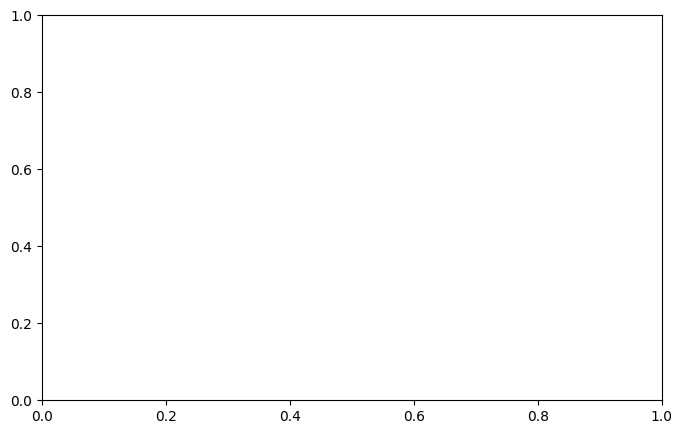

In [7]:
# Plot Win Rate Over Time
plt.figure(figsize=(8, 5))
plt.plot(range(NUM_EPISODES), win_rates, label="Win Rate")
plt.xlabel("Episodes")
plt.ylabel("Win Rate")
plt.title("Win Rate Over Time")
plt.legend()
plt.show()

# Plot Reward Over Time
plt.figure(figsize=(8, 5))
plt.plot(range(NUM_EPISODES), episode_rewards, label="Total Reward per Episode")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Agent Improvement Over Time")
plt.legend()
plt.show()